# Applied NLP: A painless introduction to text analysis through earning call transcripts
We will be using this notebook to demonstrate some techniques for text analysis (vulgo NLP) on earning call transcripts of public companies. Rather than use sample text, we will use a rich source of text that is both rich enough and not too large to be treated in a local laptop.

## Intro to NLP

For simplicity, we will assume three steps on our NLP pipeline: Text processing, feature extraction, and modelling. In fact before we model anything, we need to take into consideration two empirically verified assumptions:
1) Text is often, by its unstructured nature, noisy.
2) Models work best when data has been de-noised (e.g. try to use Computer Vision application with singificantly blurred images).

So before we are in a position to apply models to text tasks, we need to take some time processing the raw text. Let us now see what are the normal steps when we deal with Text Processing.


### 1. Text Processing

We are going to assume the following sequence of steps:

1) **Normalize by case**: Here, transform all the text to lower caps. If we are still working with a single string, we can use a single command once (str.lower()) to do that.

2) **Remove Punctutation**: This can assume different forms, but one may simply start with removing commas. This will preserve the sentence organization.

3) **Tokenization**: Until now, text was a single string, we now want to split it into sentences and words.

4) **Remove Stop Words**: Remove some of the most common words such as "and" or "this". It can also be tweaked to a specific domain.

5) **Steming/Lemmatization**: To reduced complexity, we can try to reduce related words to a common root word using Steming or Lemmatization. While Stemming reduces complexity by tryng to find a common stem around words, Lemmatization uses a known mapping to reduce words to their base form, usually depending on the syntatic function of the word (verb, noun, adverb). Note that while Lemmatization produces meaningful words, stemming may not do that.

These steps assume that we start with a raw piece of text that we progressively clean, noramlize, tokenize or split into into words, remove 'noise' in the form of frequently used words, and then try to organize words around common stems.


Let us start with loading a transcript of a sample earnings call. For the purpose, we will use Nvidia's last quarter transcript.

In [37]:
from aux import extract_call_transcript #Auxilliary function to call the API for earnings transcript
doc = extract_call_transcript('NVDA', 1, 2021) 

print(f' The transcript of the call is {len(doc)} characters long')

 The transcript of the call is 76794 characters long


If we assume that a page of single spaced text usually contains around 3000 characters, this transcript is 
around 25 pages long. Let us see read the first and last 1000 characters of the string.

In [38]:
opening_doc = doc[:1000]
closing_doc = doc[-1000:]

print('*'*107)
print(f'The opening first 1000 characters\n\n{opening_doc}')

print('*'*107)
print(f'The closing last 1000 characters\n\n {closing_doc}')

***********************************************************************************************************
The opening first 1000 characters

Operator: Good afternoon. My name is Josh, and I will be your conference operator today. At this time, I would like to welcome everyone to NVIDIA's Financial Results Conference call. [Operator Instructions].Simona Jankowski, you may begin your conference.
Simona Jankowski: Thank you. Good afternoon, everyone, and welcome to NVIDIA's conference call for the first quarter of fiscal 2021. With me on the call today from NVIDIA are Jensen Huang, President and Chief Executive Officer; and Colette Kress, Executive Vice President and Chief Financial Officer. I'd like to remind you that our call is being webcast live on NVIDIA's Investor Relations website. The webcast will be available for replay until the conference call to discuss our financial results for the second quarter of fiscal 2021. The content of today's call is NVIDIA's property. It can't be 

otice how the call opens and closes with the operator. Also, notice the spacing after the end of sentences is not uniform. One can also see the presence of the element '[Operator Instructions]' to cue a speaker. 

### 1.1 Normalization with str.lower()

Let us start by looking at the number of unique characters that the opening string contains.

In [39]:
opening_doc_unique = set(opening_doc)
print(f'There are {len(opening_doc_unique)} unique characters')

There are 56 unique characters


Let us see now what happens when we normalize the strings with str.lower().

In [40]:
doc_norm = doc.lower()
opening_doc_norm = doc_norm[:1000]
opening_doc_norm_unique = set(opening_doc_norm)
print(f'There are {len(opening_doc_norm_unique)} unique characters after normalization.')

There are 38 unique characters after normalization.


This reduction in the number of unique characters will translate to a reduction in the number of unique words, when we move to tokenization. This will offer some simplification when we pass to the representation of words, since the vocabulary will be smaller.

### 1.2 Punctuation Removal (Normalization)
Let us start by looking at the list of unique characters, and check what we have there.

In [41]:
import re
temp = ''.join(opening_doc_norm_unique)

el = re.sub(r'[a-z-0-9]', '', temp) # Keep only non alphanumerics
print(f'The non-alphanumeric characters found {repr(el)}') # Use repr to escape special characters

The non-alphanumeric characters found ".;]\n:[ ,'"


 For simplicity let us only remove commas and the special character \n.

In [42]:
doc_norm_cleaned = re.sub(r'[,\n]', "", doc_norm)
print('Raw text')
print(doc[:300])
print('*'*107)
print('\nCleaned and normalized')
print(doc_norm_cleaned[:300])

Raw text
Operator: Good afternoon. My name is Josh, and I will be your conference operator today. At this time, I would like to welcome everyone to NVIDIA's Financial Results Conference call. [Operator Instructions].Simona Jankowski, you may begin your conference.
Simona Jankowski: Thank you. Good afternoon,
***********************************************************************************************************

Cleaned and normalized
operator: good afternoon. my name is josh and i will be your conference operator today. at this time i would like to welcome everyone to nvidia's financial results conference call. [operator instructions].simona jankowski you may begin your conference.simona jankowski: thank you. good afternoon ever


As expected, commas have been removed. Let us now move to tokenization.

### 1.3 Tokenization

Before spliting into words, we start with a sentence tokenization, that is we split the string into strings. For that we will use the Punkt Sentence Tokenizer from Natural Language Toolkit. We could use much more complex models pretrained in large corpus, but for demonstration purposes, this tokenizer will suffice.

In [43]:
import nltk.data
sent_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
doc_norm_cleaned_sentencized = sent_tokenizer.tokenize(doc_norm_cleaned)
print(f'{len(doc_norm_cleaned_sentencized)} Sentences Tokenized')
print('The first 10 sentences:')
doc_norm_cleaned_sentencized[:10]

693 Sentences Tokenized
The first 10 sentences:


['operator: good afternoon.',
 'my name is josh and i will be your conference operator today.',
 "at this time i would like to welcome everyone to nvidia's financial results conference call.",
 '[operator instructions].simona jankowski you may begin your conference.simona jankowski: thank you.',
 "good afternoon everyone and welcome to nvidia's conference call for the first quarter of fiscal 2021. with me on the call today from nvidia are jensen huang president and chief executive officer; and colette kress executive vice president and chief financial officer.",
 "i'd like to remind you that our call is being webcast live on nvidia's investor relations website.",
 "the webcast will be available for replay until the conference call to discuss our financial results for the second quarter of fiscal 2021. the content of today's call is nvidia's property.",
 "it can't be reproduced or transcribed without our prior written consent.during this call we may make forward-looking statements based

In [44]:
_, max_lenght_sent, max_idx = max([(len(s), s, idx) for idx, s in enumerate(doc_norm_cleaned_sentencized)])
print(f'The sentence with the largest number of characters is at index position {max_idx}:\n')
print(max_lenght_sent)

The sentence with the largest number of characters is at index position 21:

clara imaging will continue to partner with leading research institutes to develop state-of-the-art ai models to detect infections and clara guardian will connect ai to cameras and microphones and hospitals to help overloaded staff watch over patients.we completed the acquisition of mellanox on april 27. mellanox is now nvidia's networking brand and business unit and will be reported as part of our data center market platform and israel is now one of nvidia's major technology centers.the new nvidia has a much larger footprint in data center computing end-to-end and full-stack expertise in data center architectures and tremendous scale to accelerate innovation.


If we look at the first 10 sentences above, it looks like it works ok, but after looking for the longest sentence, we can see that there are cases of multiple sentences glued together. Let us retrain the tokenizer with the help of the Reuter Corpus.

In [45]:
#nltk.download('wordnet') # you will need to download the package if you don't have it installed
from nltk.corpus import reuters
from nltk.tokenize import  PunktSentenceTokenizer
pst = PunktSentenceTokenizer()
pst.train(reuters.raw())

In [46]:
doc_norm_cleaned_sentencized = pst.sentences_from_text(doc_norm_cleaned)
print(f'{len(doc_norm_cleaned_sentencized)} Sentences Tokenized')
doc_norm_cleaned_sentencized[:10]
print('The first 10 sentences:')
doc_norm_cleaned_sentencized[:10]

696 Sentences Tokenized
The first 10 sentences:


['operator: good afternoon.',
 'my name is josh and i will be your conference operator today.',
 "at this time i would like to welcome everyone to nvidia's financial results conference call.",
 '[operator instructions].simona jankowski you may begin your conference.simona jankowski: thank you.',
 "good afternoon everyone and welcome to nvidia's conference call for the first quarter of fiscal 2021. with me on the call today from nvidia are jensen huang president and chief executive officer; and colette kress executive vice president and chief financial officer.",
 "i'd like to remind you that our call is being webcast live on nvidia's investor relations website.",
 "the webcast will be available for replay until the conference call to discuss our financial results for the second quarter of fiscal 2021. the content of today's call is nvidia's property.",
 "it can't be reproduced or transcribed without our prior written consent.during this call we may make forward-looking statements based

Compared with the above tokenization, we have now 696 sentences rather than 693, a small improvement, but still non-zero.

In [48]:
_, max_len_sent, max_idx = max([(len(s), s, idx) for idx, s in enumerate(doc_norm_cleaned_sentencized)])
print(f'The sentence with the largest number of characters is at index position {max_idx}:\n')
print(max_len_sent)

The sentence with the largest number of characters is at index position 21:

clara imaging will continue to partner with leading research institutes to develop state-of-the-art ai models to detect infections and clara guardian will connect ai to cameras and microphones and hospitals to help overloaded staff watch over patients.we completed the acquisition of mellanox on april 27. mellanox is now nvidia's networking brand and business unit and will be reported as part of our data center market platform and israel is now one of nvidia's major technology centers.the new nvidia has a much larger footprint in data center computing end-to-end and full-stack expertise in data center architectures and tremendous scale to accelerate innovation.


Still the problem with the large sentence...It looks like we didn't have a lot of luck once again. Let us bring spacy to our rescue! We will load a last-generation transformer model (roberta-base: https://huggingface.co/transformers/model_doc/roberta.html) pre-trained on a Large Corpus. When we load it with Spacy it includes all the componenets we will need. But let us focus on the tokenization.

In [49]:
# Load the transformer model and apply to our text
import spacy
nlp = spacy.load("en_core_web_trf")
doc_0 = nlp(doc_norm_cleaned)

In [51]:
doc_0_sentences = [sen for sen in doc_0.sents]
print(f'{len(doc_0_sentences)} sentences parsed with the roberta-base pretrained tokenizer.')
print('The first 33 sentences:')
doc_0_sentences[:33]

810 sentences parsed with the roberta-base pretrained tokenizer.
The first 33 sentences:


[operator: good afternoon.,
 my name is josh and i will be your conference operator today.,
 at this time i would like to welcome everyone to nvidia's financial results conference call.,
 [operator instructions].simona jankowski you may begin your,
 conference.simona jankowski: thank you.,
 good afternoon everyone and welcome to nvidia's conference call for the first quarter of fiscal 2021.,
 with me on the call today from nvidia are jensen huang president and chief executive officer; and colette kress executive vice president and chief financial officer.,
 i'd like to remind you that our call is being webcast live on nvidia's investor relations website.,
 the webcast will be available for replay until the conference call to discuss our financial results for the second quarter of fiscal 2021.,
 the content of today's call is nvidia's property.,
 it can't be reproduced or transcribed without,
 our prior written consent.during this call,
 we may make forward-looking statements based on c

The same content that was previously tokenized into 22 sentences, it is now distributed across 33 and **the number of sentences jumps from 696 to 810**! We can see how the previous sentence is now split into the 4 last sentences above. Still it looks like our cleaning may have confounded the tokenizer, by looking at the tails of some sentences. Let us put the original text in lower caps through the tokenizer and see how it looks like.

In [52]:
doc_1 = nlp(doc_norm)
doc_1_sentences = [sen for sen in doc_1.sents]
print(f'{len(doc_1_sentences)} sentences parsed with the roberta-base pretrained tokenizer on original text after normalization with lower caps.')
print('The first 35 sentences:')
doc_1_sentences[:35]

812 sentences parsed with the roberta-base pretrained tokenizer on original text after normalization with lower caps.
The first 35 sentences:


[operator: good afternoon.,
 my name is josh, and i will be your conference operator today.,
 at this time, i would like to welcome everyone to nvidia's financial results conference call.,
 [operator instructions].simona jankowski, you may begin your conference.,
 
 simona jankowski: thank you.,
 good afternoon, everyone, and welcome to nvidia's conference call for the first quarter of fiscal 2021.,
 with me on the call today from nvidia are jensen huang, president and chief executive officer; and colette kress, executive vice president and chief financial officer.,
 i'd like to remind you that our call is being webcast live on nvidia's investor relations website.,
 the webcast will be available for replay until the conference call to discuss our financial results for the second quarter of fiscal 2021.,
 the content of today's call is nvidia's property.,
 it can't be reproduced or transcribed without,
 our prior written consent.during this call,
 , we may make forward-looking statement

It looks like we have 2 more sentences after tokenization. What if we parse the raw original text?

In [54]:
doc = re.sub(r'\.([a-zA-Z])', r'. \1', doc) # Add 1 space after periods with letters
doc = re.sub('/\s\s+/g', ' ', doc) # Reduce multiple white spaces to a single space
doc_2 = nlp(doc)
doc_2_sentences  = [sen for sen in doc_2.sents]
print(f'{len(doc_2_sentences)} sentences parsed with the roberta-base pretrained tokenizer on original text after and introduction of whitespaces')

922 sentences parsed with the roberta-base pretrained tokenizer on original text after and introduction of whitespaces


What a jump in the number of sentences parsed! In fact, as we can see in the next cell, we have to go to sentence 40 to cover the span that was previously covered by the previous model in 33 sentences, and by the Punkt Tokenizer in 21!

In [57]:
print('The first 39 sentences:')
doc_2_sentences[:39]

The first 39 sentences:


[Operator:,
 Good afternoon.,
 My name is Josh, and I will be your conference operator today.,
 At this time, I would like to welcome everyone to NVIDIA's Financial Results Conference call.,
 [Operator Instructions].,
 Simona Jankowski, you may begin your conference.,
 ,
 Simona Jankowski:,
 Thank you.,
 Good afternoon, everyone, and welcome to NVIDIA's conference call for the first quarter of fiscal 2021.,
 With me on the call today from NVIDIA are Jensen Huang, President and Chief Executive Officer; and Colette Kress, Executive Vice President and Chief Financial Officer.,
 I'd like to remind you that our call is being webcast live on NVIDIA's Investor Relations website.,
 The webcast will be available for replay until the conference call to discuss our financial results for the second quarter of fiscal 2021.,
 The content of today's call is NVIDIA's property.,
 It can't be reproduced or transcribed without our prior written consent.,
 During this call, we may make forward-looking sta

In [58]:
_, max_lenght_sent, max_idx = max([(len(s), s, idx) for idx, s in enumerate(doc_2_sentences)])
print(f'The sentence with the largest number of characters is at index position {max_idx}:\n')
print(max_lenght_sent)

The sentence with the largest number of characters is at index position 512:

And the ideal GPU for that was something that has the reduced precision, which is called [indiscernible], reduced precision not with electronics that is focused more for inference -- and because inference is a scale-out application, where you have millions of queries, and each one of the queries are quite small versus scale up, where you have 1 training job and that 1 training job is running for a day.


This sentence is really a long sentence, but is correctly tokenized! Finally let us analyze all the sentences with more than one final dot. Looks like we have a winner!

In [83]:
dots_raw = [s for s in doc_norm_cleaned_sentencized if len([c for c in s if c=='.'])>1]
dots_0 = [s.text for s in doc_0_sentences if len([c for c in s.text if c=='.'])>1]
dots_1 = [s.text for s in doc_1_sentences if len([c for c in s.text if c=='.'])>1]
dots_2 = [s.text for s in doc_2_sentences if len([c for c in s.text if c=='.'])>1]

print(f'There are {len(dots_raw)} sentences with more than one dot after Punkt tokenizer is applied on cleaned and normalized text:')
print(f'There are {len(dots_0)} sentences with more than one dot after roberta tokenizer is applied on cleaned and normalized text:')
print(f'There are {len(dots_1)} sentences with more than one dot after roberta tokenizer is applied on normalized text:')
print(f'There are {len(dots_2)} sentences with more than one dot after roberta tokenizer is applied on RAW text, and they are the following:')
dots_2

There are 125 sentences with more than one dot after Punkt tokenizer is applied on cleaned and normalized text:
There are 79 sentences with more than one dot after roberta tokenizer is applied on cleaned and normalized text:
There are 61 sentences with more than one dot after roberta tokenizer is applied on normalized text:
There are 26 sentences with more than one dot after roberta tokenizer is applied on RAW text, and they are the following:


['Q1 revenue was $3.08 billion, up 39% year-on-year, down 1% sequentially and slightly ahead of our outlook, reflecting upside in our data center and gaming platforms.',
 'Revenue of $1.34 billion was up 27% year-on-year and down 10% sequentially.',
 'In real time, DLSS 2.0 can fill the missing bits from every frame, doubling performance.',
 'Quarterly revenue was a record $1.14 billion, up 80% year-on-year and up 18% sequentially, crossing the $1 billion mark for the first time.',
 'Our ecosystem is now 1.8 million developers strong.',
 'Q1 GAAP gross margins was 65.1% and non-GAAP was 65.8%, up sequentially and year-on-year, primarily driven by GeForce GPU product mix and higher data center sales.',
 'Q1 GAAP operating expenses were $1.03 billion, and non-GAAP operating expenses were $821 million, up 10% and 9% year-on-year, respectively.',
 'Q1 GAAP EPS was $1.47, up 130% from a year earlier, and non-GAAP EPS was $1.80, up 105% from a year ago.',
 'Overall, we expect second quarter 

We can see that now we are dealing with numbers or abbreviations. How about detecting questions?...

In [79]:
interrogatory_sentences = [(i, s.text) for i, s in enumerate(doc_2_sentences) if len([c for c in s.text if c=='?'])>=1] #put an index to understand where the question is
interrogatory_sentences[:10] # Just the first 10

[(192,
  "Colette, I'm curious of your commentary around visibility in the data center side, that that's comments over the last couple of quarters, how would you characterize your visibility today relative to maybe what it was last quarter?"),
 (215,
  'Were you trying to suggest that those did offset completely and gaming was kind of flattish into Q2?'),
 (217, 'I guess what were you trying to say with those kind of factors?'),
 (218,
  'And what are the kinds of things we should be thinking about when it comes to seasonality, Colette, into Q2 around that business segment?'),
 (245,
  "But do you think that the kind of -- I mean are we thinking kind of it's up somewhat?"),
 (246,
  "You don't -- is there any chance that it could be up like on -- for what we've seen in terms of like typical levels in the past?"),
 (247,
  'Like can you give us any sense of magnitude, that would be really helpful?'),
 (282, 'And is it a smooth transition?'),
 (284,
  'Just can you tell us how you see th

Clearly, we have identified the part of the transcript related to the analysts questions! Let us see if we can roughly extract the answer to those questions!

In [82]:
question_idx = [i for (i,_ ) in interrogatory_sentences]
question_dict = {i : doc_2_sentences[i-1:j] for i,j in zip(question_i, question_i[1:]) } # Take a sentence first to the question so that some context may be present"
for i, (k,v) in enumerate(question_dict.items()):
    print(f'Question + Answer {i+1} ')
    print(v)
    print('\n')

Question + Answer 1 
[Aaron Rakers: Congratulations on a solid quarter., Colette, I'm curious of your commentary around visibility in the data center side, that that's comments over the last couple of quarters, how would you characterize your visibility today relative to maybe what it was last quarter?, And how do we think about the visibility in the context of trends maybe into the back half of the calendar year., 
Colette Kress:, Thanks, Will, for the question., You are correct., We have indicated a couple of quarters ago that we were starting to see improved visibility after we came out of the digestion period in the prior overall fiscal year., As we move into Q2, we still have visibility and solid visibility into our Q2 results for overall data centers., So at this time, I'd say they are relatively about the same of what we had seen going into the Q1 period., And we think that is a true indication of their excitement about our platform and most particularly our excitement regarding

We almost got the question and answer out of the box with some simple manipulation! Since we are looking at an earnings transcript, it makes sense that we look for growth figures..

In [85]:
nums_shares_sentences = [(i, s.text) for i, s in enumerate(doc_2_sentences) if len([c for c in s.text if c=='$' or c=='%'])>=1]
for (i,s)in nums_shares_sentences:
    print(s)

We've pooled in raises by 6 months to put more money in our employees' hands, and NVIDIA and our people have donated thus far more than $10 million to those in need.
Q1 revenue was $3.08 billion, up 39% year-on-year, down 1% sequentially and slightly ahead of our outlook, reflecting upside in our data center and gaming platforms.
Revenue of $1.34 billion was up 27% year-on-year and down 10% sequentially.
Globally, we have seen 50% rise in gaming hours played on our GeForce platform, driven both by more people playing and more gameplay per user.
In addition, OEMs are bringing to market laptops based on the RTX 2060 GPU at just $999, a price point that enables a larger audience to take advantage of the power and features of RTX, including its unique ray tracing and AI capabilities.
Revenue was $307 million, up 15% year-on-year and down 7% sequentially.
Automotive revenue was $155 million, down 7% year-on-year and down 5% sequentially.
likely declining about 40% from Q1.
Quarterly revenue

We can clearly see the power of good tokenization. And this is just the begining. Later we will use Name entity recognition to make a more precise identification, such as when numerals are stated as ordinals, for instance.

### 1.3.2 Work Tokenization
The package nltk contains several word tokenizers. Here, we will use the Twitter Tokenizer, which is a basic tokenizer that can detect twitter handles.

In [86]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
# Remove the dot in the sentences
doc_norm_cleaned_sentencized_tokenized = [tokenizer.tokenize(sent.replace('.', " ")) for sent in doc_norm_cleaned_sentencized]
for sent in doc_norm_cleaned_sentencized_tokenized[:5]:
    print(sent)

['operator', ':', 'good', 'afternoon']
['my', 'name', 'is', 'josh', 'and', 'i', 'will', 'be', 'your', 'conference', 'operator', 'today']
['at', 'this', 'time', 'i', 'would', 'like', 'to', 'welcome', 'everyone', 'to', "nvidia's", 'financial', 'results', 'conference', 'call']
['[', 'operator', 'instructions', ']', 'simona', 'jankowski', 'you', 'may', 'begin', 'your', 'conference', 'simona', 'jankowski', ':', 'thank', 'you']
['good', 'afternoon', 'everyone', 'and', 'welcome', 'to', "nvidia's", 'conference', 'call', 'for', 'the', 'first', 'quarter', 'of', 'fiscal', '2021', 'with', 'me', 'on', 'the', 'call', 'today', 'from', 'nvidia', 'are', 'jensen', 'huang', 'president', 'and', 'chief', 'executive', 'officer', ';', 'and', 'colette', 'kress', 'executive', 'vice', 'president', 'and', 'chief', 'financial', 'officer']


Let us see how the distribution of the length of the strings is when measured by the number of words.

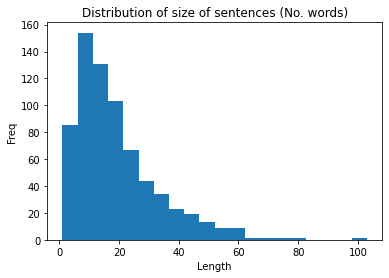

In [87]:
count_words = [len(sen) for sen in doc_norm_cleaned_sentencized_tokenized]
plt.hist(count_words, bins=20)
plt.title('Distribution of size of sentences (No. words)')
plt.xlabel('Length')
plt.ylabel('Freq')
plt.show()

As expected, there is a high correlation between the number of characters a sentence contains and the number of words. This probably due to the distribution of the length of the words across the document.

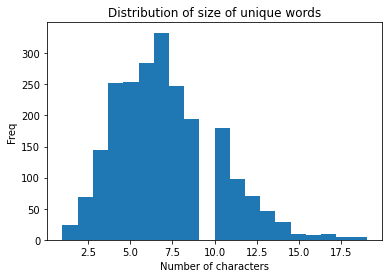

In [88]:
bag_words = tokenizer.tokenize(re.sub(r'([.,:;-])', '', doc_norm_cleaned)) #Tokenize into words
unique_words = list(set(bag_words))
unique_words_len = [len(w) for w in unique_words]
plt.hist(unique_words_len, bins=20)
plt.title('Distribution of size of unique words')
plt.xlabel('Number of characters')
plt.ylabel('Freq')
plt.show()

We finish by having a look at our doc_2 object, which already contains the words parsed for us, when we built the the spacy doc_2 object.

In [90]:
doc_sent_roberta = [[w.text for w in s] for s in doc_2.sents]

### 1.4 Stop Words

In the context of NLP pipelines, stop words are those that appear with such a high frequency (e.g. "and", the", "of") that by themselves are unlikely to help differentiate between values. Let us see for our case what are the 50 top words, by frequency.

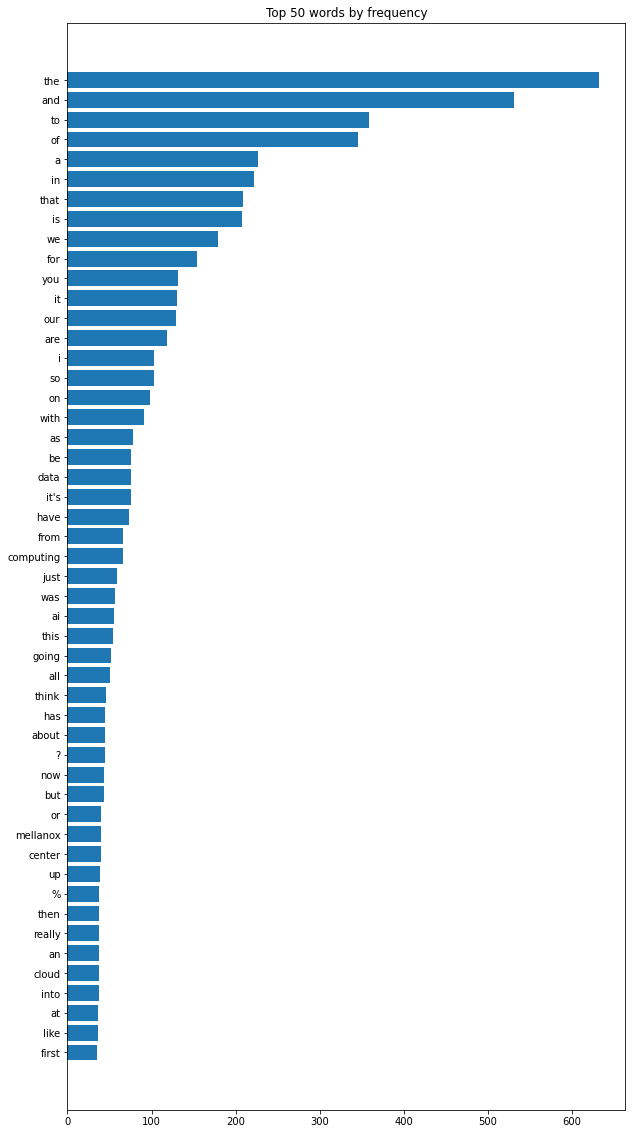

In [91]:
from collections import Counter
import numpy as np
count_words = Counter(bag_words)
top_words = np.array(count_words.most_common(50))
fig, ax = plt.subplots(figsize=(10,20))
ax.barh(np.flip(top_words[:,0]), np.flip(top_words[:,1]).astype(np.int32))
plt.title('Top 50 words by frequency')
plt.show()

Let us see how they compare with the stopwords list included in the nltk package.

In [92]:
from nltk.corpus import stopwords
nltk.download("stopwords")
stop = stopwords.words("english")
intersect  = set(stop).intersection(set(top_words[:,0]))
print(f'There are {len(intersect)} common stop words: {intersect}')

There are 37 common stop words: {'of', 'so', 'at', 'it', 'all', 'about', 'an', 'the', 'up', 'with', 'has', 'into', 'is', 'for', 'as', "it's", 'then', 'a', 'in', 'that', 'or', 'on', 'i', 'our', 'are', 'just', 'and', 'this', 'now', 'you', 'we', 'but', 'to', 'be', 'was', 'have', 'from'}


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sapereira/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We can see that out of 50 top words, 37 are contained in the nltk stop words. Let's remove them. We end up with two objects: The naive construction that we have build with the help of nltk, and the roberta, which we built by using the transformed pre-trained model of spacy,

In [ ]:
doc_processed_naive = [ [w for w in s if w not in stop] for s in doc_norm_cleaned_sentencized_tokenized] 
doc_processed_roberta = doc_2.copy()

### 1.5 Stemming and Lemmatization 
Here we apply a common Stemmer, the PorterStemmer from NLTk first. Then, we use the lemmatizer attached to our model from spacy. We will not apply this to our current model though.

In [93]:
from nltk.stem import PorterStemmer
  
ps = PorterStemmer()
sent = doc_sent_roberta[35]
doc_lemmas_roberta = [[(w.text, w.lemma_) for w in s] for s in doc_2.sents]
print(f'Sentence to stemm and lemmatize: {sent}')
print(f'\nTokenized sentence to stemm and lemmatize: {sent}')
print('Stemming')
print('word', " | ", 'stem')
for w in sent:
    print(w, " : ", ps.stem(w))
    
print('word', " | ", 'lemma')
for (w, lemma) in doc_lemmas_roberta[35]:
    print(w, " : ", lemma)

Sentence to stemm and lemmatize: ['We', 'are', 'racing', 'to', 'deploy', 'the', 'NVIDIA', 'Clara', 'computational', 'health', 'care', 'platforms', ',', 'Clara', 'Parabricks', 'can', 'accelerate', 'genomics', 'analysis', 'from', 'days', 'to', 'minutes', '.']

Tokenized sentence to stemm and lemmatize: ['We', 'are', 'racing', 'to', 'deploy', 'the', 'NVIDIA', 'Clara', 'computational', 'health', 'care', 'platforms', ',', 'Clara', 'Parabricks', 'can', 'accelerate', 'genomics', 'analysis', 'from', 'days', 'to', 'minutes', '.']
Stemming
word  |  stem
We  :  we
are  :  are
racing  :  race
to  :  to
deploy  :  deploy
the  :  the
NVIDIA  :  nvidia
Clara  :  clara
computational  :  comput
health  :  health
care  :  care
platforms  :  platform
,  :  ,
Clara  :  clara
Parabricks  :  parabrick
can  :  can
accelerate  :  acceler
genomics  :  genom
analysis  :  analysi
from  :  from
days  :  day
to  :  to
minutes  :  minut
.  :  .
word  |  lemma
We  :  we
are  :  be
racing  :  racing
to  :  to
deploy 

We can see that the righ-hand side words when we apply the Porter Stemmer seem to be cut, while if we apply the Lemmatization they actually are transformed into meaningful roots.
There is much more to exlore on spacy pre-trained models, but let us stop the text processing and move the feature extraction.

## 2. Feature Extraction

Since models do not work with words directly, we have to transform them somehow into tokens that can be read by models. The way to do this is generally to transformterms or sentences into vector-representations.

### 2.1 Bag of Words 
Bag of words constructs an array of dimension #{Sentences} $\times$ #{unique_words} of 0s and 1s based on whether a certain word is present in the sentence. So we cannot use
the tokenization immediately, and need to be at sentence level.

In [94]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_bw = CountVectorizer() 
doc_bag_words = vectorizer_bw.fit_transform(doc_norm_cleaned_sentencized)
doc_bag_words

<696x2077 sparse matrix of type '<class 'numpy.int64'>'
	with 11122 stored elements in Compressed Sparse Row format>

Interestingly, it is saved as a sparse matrix, because a very large part of the elements are 0. Let us see how they look like. We can see that a large vocabulary will translate into
a very sparse matrix.

In [95]:
features = vectorizer_bw.get_feature_names()
print(f'{len(features)} different features')
print(doc_bag_words.toarray())

2077 different features
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]]


Let us look at the last sentence, and verify that the element in the position -3 of the feature names is there.

In [96]:
print(doc_norm_cleaned_sentencized[-1])
print(features[-3])

you may now disconnect.
you


Note that this model only indicates whether a word is present in a sentence. Better would be to have
some information about the frequency so that we can try to compute similarity of sentences based on the frequency of the distributions.

### 2.2 Term Frequency Times Inverse Document Frequency 
#### 2.2.1. Theory and toy example
TF-IDF is based on the intitution that words that are more unique in a sentence (originally the name is "document" where document is the subunit of the document). Let us assume that our corpus is "the little little lion" "the little house", which gives us the features ("the", "little", "lion", "house"). We can then encode our documents into

$\begin{pmatrix}1 & 1 & 1 & 0 \\ 1 & 1 & 0 & 1\end{pmatrix}$

Now, as we have mentioned above, bag of words 
The way to calculate that is to use the original bag of words, but instead of using for encoding the presence we allow the following transformation:
1) The entries correspond to the frequency of the word in the sentence. So, "the little little lion" gets transformed into (1, 2, 1, 0) and "the little house" into (1,1,0,1). This can be accomplished by using the CountVectorizer from sklearn.

2) We could normalize these frequencies by the number of terms in the document, which then yields after stacking the two vectors,

$\begin{pmatrix} \frac14 & \frac12 & \frac14 & 0 \\ \frac13 & \frac13 & 0 & \frac13 \end{pmatrix}$

Now, we can see that the matrix above represents the density of the words across independent documents (the rows). In order to relate those frequencies with the overall distribution of the document, we need to weight those frequencies by "something" that considers the relation of the terms across different documents. This is what the Inverse Document Frequency does. However with a different nomalization from step 2. 

In the case of TFIDF, we multiply the original term frequency (the vectors in step 1 above) by the inverse document frequency which, for a term  in a  document $d_i$, $w_{d_i}$ is defined as the logarithm of the ratio between the number of total documents and the number of documents that contain $w_{d_i}$

$(\frac{#\{Documents\}}{#\{d \in D: w_{d_i}} \in d_i \}$



Thus the original BoW transformation becomes for ("the", "little", "lion", "house")

$\begin{pmatrix} 1 \cdot \log(\frac{2+1}{2 +1}) & 2  \cdot \log(\frac{2+1}{1 + 1}) & 1 \cdot \log(\frac{2+1}{2+1}) & 0 \\ 1 \cdot  log(\frac{2+1}{2 + 1}) & 1 \cdot  \log(\frac{2+1}{2 + 1}) & 0 & 1 \cdot \log(\frac{2+1}{1+1}) \end{pmatrix}$

Note how the count vectorizer is multiplying element-wise the log terms.

Finally, we just need to normalize the above rows by their l-2 or l-1 norm.

The default implementation from Sklearn is slightly different form this one, since it consists of the following additional steps:
* Add 1 to the both the denominator and numerator of fraction inside the logarithmic: This prevents division by zero in case new documents contain unseen words.
* It uses l-2 norm.



In [97]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

toy_corpus = ['the little little house', 'the little lion']
toy_tfidf = TfidfVectorizer()
toy_counterv = CountVectorizer()
toy_tfidf = toy_tfidf.fit_transform(toy_corpus) 
toy_count = toy_counterv.fit_transform(toy_corpus)
toy_count_ar = toy_count.toarray()
toy_tfidf_ar = toy_tfidf.toarray()


print(f'Order of the features')
print(toy_counterv.get_feature_names())
print(f'\nCount Vectorizer output')
toy_count_ar = toy_count.toarray()
print(toy_count_ar)
print(f'\nSklearn TFIDF Vectorizer output')
print(toy_tfidf_ar)


Order of the features
['house', 'lion', 'little', 'the']

Count Vectorizer output
[[1 0 2 1]
 [0 1 1 1]]

Sklearn TFIDF Vectorizer output
[[0.53215436 0.         0.75726441 0.37863221]
 [0.         0.70490949 0.50154891 0.50154891]]


Let us now replicate the value of the output given by the sklearn. Note that the term frequency is given by the Count Vectorizer, so what we will be doing is applying a weighting scheme as described above.

In [98]:
import numpy as np

N=len(toy_count_ar)# The number of documents
term_vec = (toy_count_ar > 0).astype(np.float32).sum(axis=0) # Calculate the term frequency
tfidf_toy = toy_count_ar *  (np.log((1+ N) * np.reciprocal(term_vec + 1)) + 1)
print(f'The number of occurences of the word-features across all documents: {term_vec}')
print(f'\nThe TF-IDF components before normalization:\n {tfidf_toy}')
tfidf_norm = tfidf_toy/ np.linalg.norm(tfidf_toy, axis=1)[:, np.newaxis]
print(f'\nThe normalized TF-IDF componenets: \n {tfidf_norm}')

The number of occurences of the word-features across all documents: [1. 1. 2. 2.]

The TF-IDF components before normalization:
 [[1.40546513 0.         2.         1.        ]
 [0.         1.40546513 1.         1.        ]]

The normalized TF-IDF componenets: 
 [[0.53215436 0.         0.75726441 0.37863221]
 [0.         0.70490949 0.5015489  0.5015489 ]]


We can see that the word "lion" is more unique than "house" given that the sentence from where it is extracted is longer. We can now move to our real exammple on the earning tanscript.

In [99]:
tfidf_vectorizer = TfidfVectorizer()
earnings_transformed = tfidf_vectorizer.fit_transform(doc_norm_cleaned_sentencized)
assert features == tfidf_vectorizer.get_feature_names() # We don't need to do this since the order is the same as the vecotrizer
freqs = earnings_transformed.toarray()

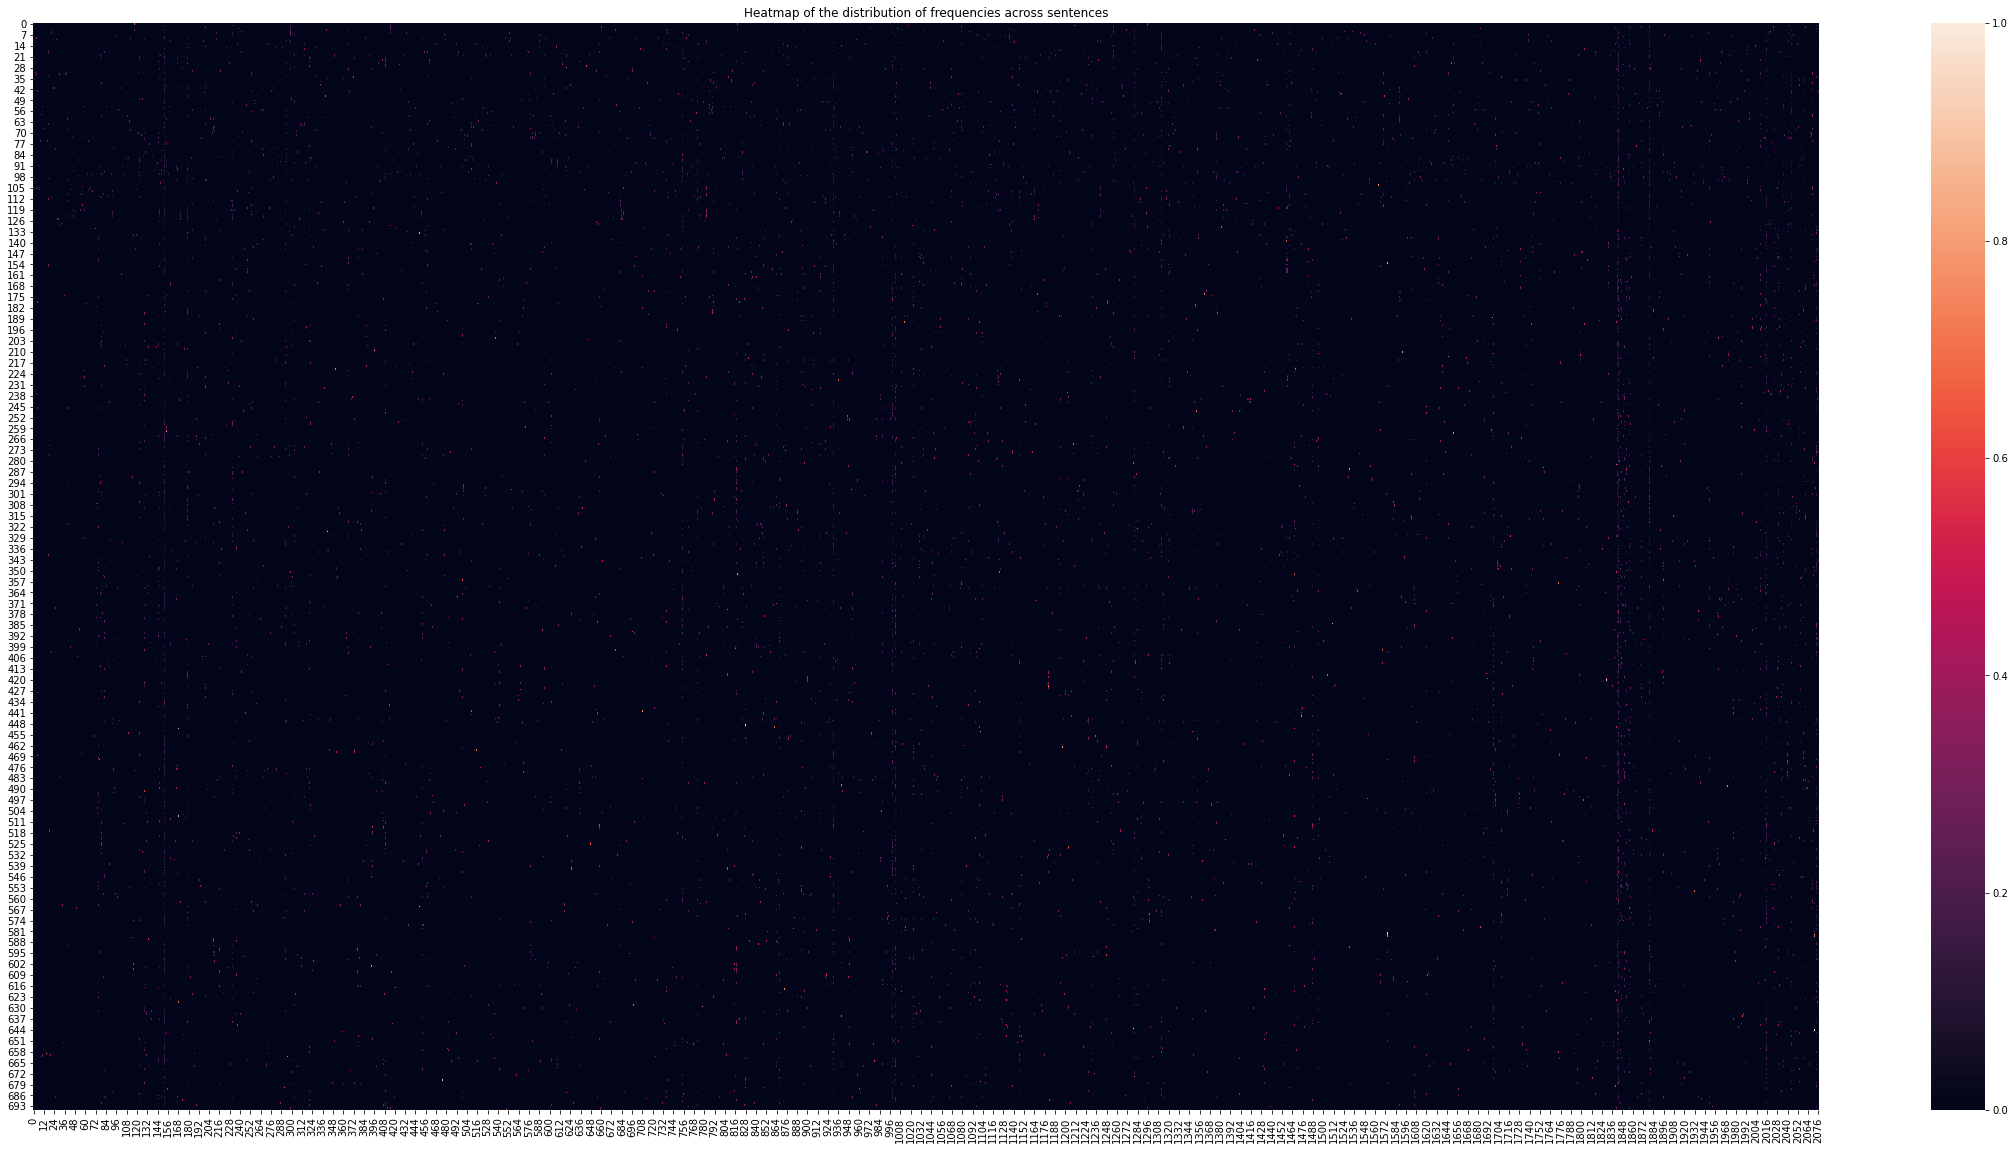

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(40,20))
ax = sns.heatmap(freqs)
plt.title('Heatmap of the distribution of frequencies across sentences')
plt.show()

We can see that preety much everything is zero, with some scattered light dots corresponding to higher frequencies. This is indeed a very sparse matrix, which is big issues when the vocabulary is large.

Instead of guessing let us which words are the most important and the corresponding sentences.

In [101]:
idx_max = np.unravel_index(np.argmax(freqs, axis=None), freqs.shape)
print(idx_max)

(449, 828)


In [102]:
doc_norm_cleaned_sentencized[449]


'great.'

Not so "great", seeing that the highest frequency is actually coming from a sentence with a single word. 
Let us see the relationship between words and the frequencies.

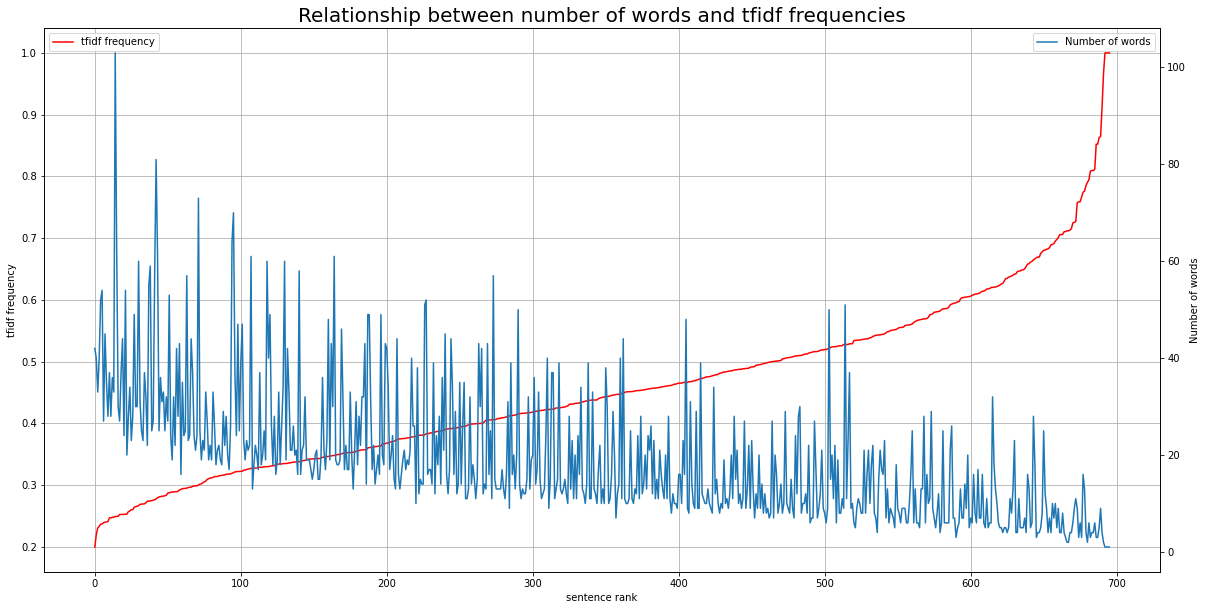

In [106]:
# Create an a vector with the maximum
max_freq_sentences = freqs.max(axis=1)
fig, ax1 = plt.subplots(figsize=(20,10))

count_words = [len(sen) for sen in doc_norm_cleaned_sentencized_tokenized]

# Sort the count_words by the order corresponding to the max_fre
count_sorted_by_freq = np.array(count_words)[np.argsort(max_freq_sentences)]
ax1.set_xlabel('sentence rank')
ax1.set_ylabel('tfidf frequency')
ax1.plot(np.sort(max_freq_sentences), color='r', label='tfidf frequency')
ax1.grid()
ax1.legend(loc=2)

ax2 = ax1.twinx()
ax2.set_ylabel('Number of words')
ax2.plot(count_sorted_by_freq, label='Number of words')
ax2.legend(loc=0)


plt.title('Relationship between number of words and tfidf frequencies', fontsize=20)
plt.show()
#plt.plot(max_sentences)
#plt.plot(count_words)


There seems to be an inverse relationship between the number of words and frequency. This suggests that we may have to remove the influence of the size of the sentence from the importance of the word, or will have to have to factor that when making computations. As next step to encode text, is not encode group of tokens (i.e sentences into sparse vectors), but encode them into a fixed-dimensional space that preserve some expected properties such similarity for instance. That is the objective of the Embedding schemes, homeomorphisms between a Corpus and a subset of the n-dimensional vector space. Let us describe some of those.

### 2.3 Word2Vec, Glove, and FastText

These models are some of the most well-known models of embeddings. While word2vec embeds words by focusing on context, Glove, takes into consideration co-occurence, that is 
how often two words appear in the vicinity of each other. Glove is an embedding that not only is aware of local context as word2vec but uses the co-ocurrence to provide global awareness.
Let's see them in practice.

In [227]:
import gensim.downloader

# load a g
# load a glove and word2vec pre-trained model
#glove_vectors = gensim.downloader.load('glove-wiki-gigaword-50')
word2vec_vectors = gensim.downloader.load('word2vec-google-news-300')

[=================================================-] 100.0% 1662.2/1662.8MB downloaded


In [233]:
print('glove')
print(glove_vectors.most_similar(positive=['revenue'],topn=20)) # Simple example with the word of the company
print('word2vec')
word2vec_vectors.most_similar(positive=['revenue'],topn=20)

glove
[('revenues', 0.9638381600379944), ('profits', 0.8603043556213379), ('income', 0.856619656085968), ('profit', 0.8461629152297974), ('costs', 0.8377888798713684), ('sales', 0.8291324377059937), ('value', 0.8240885138511658), ('net', 0.8200995922088623), ('cost', 0.8198602795600891), ('earnings', 0.8161572217941284), ('increase', 0.8114431500434875), ('billion', 0.7960667014122009), ('excluding', 0.7897192239761353), ('cash', 0.7870171666145325), ('savings', 0.7859839200973511), ('projected', 0.7794065475463867), ('increased', 0.7752556204795837), ('surplus', 0.7739671468734741), ('expenditure', 0.7692553997039795), ('exceeded', 0.7687921524047852)]
word2vec


[('revenues', 0.9205818772315979),
 ('Revenues', 0.6460289359092712),
 ('Revenue', 0.6431365013122559),
 ('profits', 0.6183733344078064),
 ('sales', 0.5952508449554443),
 ('revenue_streams', 0.5900517702102661),
 ('revnue', 0.583410918712616),
 ('profit', 0.5829346179962158),
 ('gross_margin', 0.5647226572036743),
 ('fiscal', 0.5502817630767822),
 ('profitability', 0.5387187004089355),
 ('gross_margins', 0.537239134311676),
 ('income', 0.5368183255195618),
 ('reve_nue', 0.528989315032959),
 ('MCDL', 0.5274255275726318),
 ('transient_occupancy_taxes', 0.5216386318206787),
 ('millionfor', 0.5212879776954651),
 ('cash_flow', 0.5212779641151428),
 ('earnings', 0.5212116241455078),
 ('License_Fees', 0.5208850502967834)]

In [ ]:
pi

In [220]:
word2vec_vectors = gensim.downk('word2vec-ruscorpora-300')

AttributeError: module 'gensim' has no attribute 'dowloader'

In [ ]:
import spacy
from extractors import extract_call_transcript
import pandas as pd



# Load the Loughran-McDonlad sentiment words based on 10-k filings
# https://drive.google.com/file/d/15UPaF2xJLSVz8DYuphierz67trCxFLcl/view
word_map = pd.read_pickle('data/LM_Sentiment.pkl')
print(f'There is sentiment tagging for {word_map.shape[0]} words.')
obj = extract_call_transcript('TWTR',1, 2021)
text = obj[0].get('content')

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
#from transformers import pipeline
#sentiment_analysis = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english")




In [2]:
nlp = spacy.load("en_core_web_trf")
doc = nlp(text)

In [3]:
def analyze_sentiment(doc, word_map):
    tokens = [token.text.lower() for token in doc]
    tokens_map = word_map[word_map['Word'].isin(tokens)]
    return tokens_map


sentiment_freq = analyze_sentiment(doc, word_map)

In [4]:
sentiment_freq['Word'].values

array(['aftermath', 'against', 'concerned', 'confused', 'delay',
       'delayed', 'drag', 'exacerbated', 'failed', 'missed', 'opposed',
       'problem', 'question', 'questions', 'slow', 'slowed', 'slower',
       'slowness', 'urgency', 'worry', 'able', 'achieve', 'advantage',
       'benefiting', 'best', 'better', 'boost', 'confident', 'easier',
       'easily', 'easy', 'enabling', 'excited', 'exclusively', 'gain',
       'gaining', 'good', 'great', 'greater', 'highest', 'improve',
       'improved', 'improvement', 'improvements', 'improving',
       'opportunities', 'opportunity', 'pleased', 'positive',
       'positively', 'progress', 'solving', 'strength', 'strong',
       'stronger', 'success', 'successful', 'assumes', 'assuming',
       'believe', 'could', 'may', 'maybe', 'might', 'nearly', 'possible',
       'seems', 'sometimes', 'unidentified', 'unusual', 'varied', 'vary',
       'remediate', 'whatever', 'always', 'best', 'definitely', 'highest',
       'must', 'never', 'will'

In [5]:
#from nltk.lm.preprocessing import padded_everygram_pipeline
#train, vocab = padded_everygram_pipeline(2, text)

In [6]:
#nlp.add_pipe("sentencizer")
from spacy.lang.en.stop_words import STOP_WORDS
doc_2 = nlp(text)
text_split = [sent for sent in doc_2.sents]

In [7]:
text_split_2 = [[token.text.lower() for token in sent] for sent in doc_2.sents]

In [8]:
unique_sent =  word_map['Sentiment'].unique()
word_map_dict = {k: word_map[word_map['Sentiment'] == k]['Word'].unique() for k in unique_sent}
#print(word_map_dict)
sentiment_sentences = {k: [sent.text for sent in text_split if len(set([token.text.lower() for token in sent]).intersection(v)) > 0] for k, v in word_map_dict.items()}


In [9]:
from collections import Counter
count = Counter(sentiment_sentences)
for k, v in sentiment_sentences.items():
    print(k, len(v))


Negative 58
Positive 103
Uncertainty 43
Litigious 2
StrongModal 29
WeakModal 29
Constraining 1


In [11]:
def sentiment_sentences_n_degree(n, text_split):
    sentiment_sentences = {k: [sent.text for sent in text_split if
                               len(set([token.text.lower() for token in sent]).intersection(v)) >= n] for k, v in word_map_dict.items()}
    return sentiment_sentences

In [12]:
sentiment_2 = sentiment_sentences_n_degree(n=2, text_split=text_split)
for k, v in sentiment_2.items():
    print(k, len(v))

Negative 3
Positive 24
Uncertainty 2
Litigious 0
StrongModal 1
WeakModal 2
Constraining 0


In [15]:
sent = []
for pre_pos in sentiment_2['Positive']:
    sent.append((pre_pos, sentiment_analysis(pre_pos)))
    
    

In [16]:
print(sent)

[("Overall, we're benefiting from a growing audience, better ad formats, improved relevance, and strong secular trends.", [{'label': 'POSITIVE', 'score': 0.998881459236145}]), ("We're attracting more great people to Twitter than ever before and investing in our highest priorities to deliver on our long-term goals across consumer products, revenue products, and platform.", [{'label': 'POSITIVE', 'score': 0.9988465309143066}]), ("Long term, we're confident that our brand advertising strength and better performance products position us well to help advertisers achieve their goals.", [{'label': 'POSITIVE', 'score': 0.9989072680473328}]), ("Those MAP advertisers, who advertise into those areas to have people download their apps for a crypto or investing or betting, they 10x-ed their spend in Q1 relative to what they spent last year, demonstrating how we're benefiting from one of these strong secular trends and we have a large and growing audience and an active conversation around the topic 

In [35]:
word_map_ = word_map.set_index('Sentiment', drop=True)
word_map.drop('index', inplace=True, axis=1)

In [38]:
word_map_s =

,Word,Sentiment
0,abandon,Negative
1,abandoned,Negative
2,abandoning,Negative
3,abandonment,Negative
4,abandonments,Negative
...,...,...
4135,stricter,Constraining
4136,strictest,Constraining
4137,strictly,Constraining
4138,unavailability,Constraining


In [117]:
from transformers import pipeline
sentiment_analysis = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english")

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [ ]:
word_map[word_map['Word'].isin()]

In [131]:
obj = extract_call_transcript('NVDA',1, 2021)
text = obj[0].get('content')
doc = nlp(text)
spacy.displacy.serve(doc, style='ent' )

/Users/sapereira/anaconda3/envs/nlp/lib/python3.9/site-packages/spacy/displacy/__init__.py:97: UserWarning: [W011] It looks like you're calling displacy.serve from within a Jupyter notebook or a similar environment. This likely means you're already running a local web server, so there's no need to make displaCy start another one. Instead, you should be able to replace displacy.serve with displacy.render to show the visualization.
  warnings.warn(Warnings.W011)



Using the 'ent' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.


In [193]:
import numpy as np
sents_ents = [(np.array([[token, token.pos_, token.dep_] for token in sent]) , sent) for sent in doc.sents]
def is_nums(sent):
    return True if 'NUM' in sent[0][:, 1] else False
is_nums(sents_ents[23])    
sents_ents[23][1]

Before Colette describes our quarterly results, I'd like to thank those who are on the front lines of this crisis, first responders, health care workers, service providers, who inspires every day with their bravery and selflessness.

In [186]:
sents_ents[50]

(array([[Q1, 'PROPN', 'compound', Q1],
        [revenue, 'NOUN', 'nsubj', revenue],
        [was, 'AUX', 'ROOT', was],
        [$, 'SYM', 'quantmod', $],
        [3.08, 'NUM', 'compound', 3.08],
        [billion, 'NUM', 'attr', billion],
        [,, 'PUNCT', 'punct', ,],
        [up, 'ADV', 'advmod', up],
        [39, 'NUM', 'nummod', 39],
        [%, 'NOUN', 'npadvmod', %],
        [year, 'NOUN', 'npadvmod', year],
        [-, 'PUNCT', 'punct', -],
        [on, 'ADP', 'prep', on],
        [-, 'PUNCT', 'punct', -],
        [year, 'NOUN', 'pobj', year],
        [,, 'PUNCT', 'punct', ,],
        [down, 'ADV', 'advmod', down],
        [1, 'NUM', 'nummod', 1],
        [%, 'NOUN', 'npadvmod', %],
        [sequentially, 'ADV', 'advmod', sequentially],
        [and, 'CCONJ', 'cc', and],
        [slightly, 'ADV', 'advmod', slightly],
        [ahead, 'ADV', 'conj', ahead],
        [of, 'ADP', 'prep', of],
        [our, 'PRON', 'poss', our],
        [outlook, 'NOUN', 'pobj', outlook],
        [,

In [166]:
filtered_sentences = [sent[1].text for sent in sents_ents if is_nums(sent)]
filtered_text = ''.join(filtered_sentences)
print(f'After filtering those sentences contatining at least one numeric entity we reduce from {len(sents_ents)} to {len(filtered_sentences)} sentences')
filtered_doc = nlp(filtered_text)
spacy.displacy.render(filtered_doc, style='ent', jupyter=True)

After filtering those sentences contatining at least one numeric entity we reduce from 922 to 167 sentences


In [133]:
from extractors import extract_next_earnings
earnings_dict = extract_next_earnings(start_date='2021-05-25', end_date='2021-05-29')


In [134]:
df_earnings_next[df_earnings_next['symbol']=='NVDA']


,date,symbol,eps,epsEstimated,time,revenue,revenueEstimated
62,2021-05-26,NVDA,None,3.27,amc,0,5318430000


In [29]:
import extractors
dir(extractors)

['API_KEY',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'datetime',
 'extract_call_transcript',
 'extract_fundamentals_bs',
 'extract_fundamentals_cf',
 'extract_fundamentals_is',
 'extract_gainers',
 'extract_list',
 'extract_losers',
 'extract_next_earnings',
 'extract_press_releases',
 'extract_price_live',
 'extract_prices_history',
 'extract_prices_live',
 'extract_prices_sector',
 'extract_sec_fillings',
 'extract_sector_industry',
 'get_jsonparsed_data',
 'load_tickers',
 'pd']

In [135]:
from extract_earnings import extract_earnings_surprises

In [138]:
df_surprises = extract_earnings_surprises(['NVDA'])
df_surprises['surprise_percent'] = 100 * (df_surprises['actualEarningResult']/ df_surprises['estimatedEarning']  - 1)

In [139]:
df_surprises

,date,symbol,actualEarningResult,estimatedEarning,surprise_percent
0,2021-02-24,NVDA,3.10,2.81,10.320285
1,2020-11-18,NVDA,2.91,2.57,13.229572
2,2020-08-19,NVDA,2.18,1.97,10.659898
3,2020-05-21,NVDA,1.80,1.69,6.508876
4,2020-02-13,NVDA,1.89,1.67,13.173653
5,2019-11-14,NVDA,1.78,1.57,13.375796
6,2019-08-15,NVDA,1.24,1.15,7.826087
7,2019-05-16,NVDA,0.88,0.81,8.641975
8,2019-02-14,NVDA,0.80,0.75,6.666667
9,2018-11-15,NVDA,1.84,1.87,-1.604278


In [42]:
df_surprises

,date,symbol,actualEarningResult,estimatedEarning,surprise_percent
0,2021-02-24,NVDA,3.10,2.81,10.320285
1,2020-11-18,NVDA,2.91,2.57,13.229572
2,2020-08-19,NVDA,2.18,1.97,10.659898
3,2020-05-21,NVDA,1.80,1.69,6.508876
4,2020-02-13,NVDA,1.89,1.67,13.173653
5,2019-11-14,NVDA,1.78,1.57,13.375796
6,2019-08-15,NVDA,1.24,1.15,7.826087
7,2019-05-16,NVDA,0.88,0.81,8.641975
8,2019-02-14,NVDA,0.80,0.75,6.666667
9,2018-11-15,NVDA,1.84,1.87,-1.604278
